In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import resize
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os
from testing.aml_utils_ClassifyingImages import show_test_cases, test_case_checker, perform_computation

Libraries such as `math` are neither as accurate nor as efficient as `numpy`.

**Note**: Do not import or use any other libraries other than what is already imported above. 

# *Assignment Summary

You may find it useful to read Chapter 1 and 2 of the textbook about classification.

The MNIST dataset is a dataset of 60,000 training and 10,000 test examples of handwritten digits, originally constructed by Yann Lecun, Corinna Cortes, and Christopher J.C. Burges. It is very widely used to check simple methods. There are 10 classes in total ("0" to "9"). This dataset has been extensively studied, and there is a history of methods and feature constructions at https://en.wikipedia.org/wiki/MNIST_database and at the original site, http://yann.lecun.com/exdb/mnist/ . You should notice that the best methods perform extremely well.

There is also a version of the data that was used for a Kaggle competition. I used it for convenience so I wouldn't have to decompress Lecun's original format. I found it at http://www.kaggle.com/c/digit-recognizer .

Regardless of which format you find the dataset stored in, the dataset consists of 28 x 28 images. These were originally binary images, but appear to be grey level images as a result of some anti-aliasing. We will ignore mid grey pixels (there aren't many of them) and call dark pixels "ink pixels", and light pixels "paper pixels"; you can modify the data values with a threshold to specify the distinction, as described here https://en.wikipedia.org/wiki/Thresholding_(image_processing) . The digit has been centered in the image by centering the center of gravity of the image pixels, but as mentioned on the original site, this is probably not ideal. Here are some options for re-centering the digits that I will refer to in the exercises.

  * **Untouched**: Do not re-center the digits, but use the images as is.
  
  * **Bounding box**: Construct a 20 x 20 bounding box so that the horizontal (resp. vertical) range of ink pixels is centered in the box.

  * **Stretched bounding box**: Construct a 20 x 20 bounding box so that the horizontal (resp. vertical) range of ink pixels runs the full horizontal (resp. vertical) range of the box. Obtaining this representation will involve rescaling image pixels: you find the horizontal and vertical ink range, cut that out of the original image, then resize the result to 20 x 20. Once the image has been re-centered, you can compute features.
  
Here are some pictures, which may help.

![alt text](./images/bounding_v2.png "Illustrations of the bounding box options described in text")

**Part 2A** Investigate classifying MNIST using naive Bayes. Fill in the accuracy values for the four combinations of Gaussian v. Bernoulli distributions and untouched images v. stretched bounding boxes in a table like this. Please use 20 x 20 for your bounding box dimensions.

<table width="400" border="1">
  <tbody>
    <tr>
      <th scope="col"> Accuracy</th>
      <th scope="col">Gaussian</th>
      <th scope="col">Bernoulli</th>
    </tr>
    <tr>
      <th scope="row">Untouched images</th>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <th scope="row">Stretched bounding box</th>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
    </tr>
  </tbody>
</table>
Which distribution (Gaussian or Bernoulli) is better for untouched pixels? Which is better for stretched bounding box images?

**Part 2B** Investigate classifying MNIST using a decision forest. For this you should use a library. For your forest construction, try out and compare the combinations of parameters shown in the table (i.e. depth of tree, number of trees, etc.) by listing the accuracy for each of the following cases: untouched raw pixels; stretched bounding box. Please use 20 x 20 for your bounding box dimensions. In each case, fill in a table like those shown below.

<table width="400" border="1">
  <tbody>
    <tr>
      <th scope="col">Accuracy</th>
      <th scope="col">depth = 4</th>
      <th scope="col">depth = 8</th>
      <th scope="col">depth = 16</th>
    </tr>
    <tr>
      <th scope="row">#trees = 10</th>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <th scope="row">#trees = 20</th>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <th scope="row">#trees = 30</th>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
    </tr>
  </tbody>
</table> 	 	 

# 0. Data

Since the MNIST data (http://yann.lecun.com/exdb/mnist/) is stored in a binary format, we would rather have an API handle the loading for us. 

Pytorch (https://pytorch.org/) is an Automatic Differentiation library that we may see and use later in the course. 

Torchvision (https://pytorch.org/docs/stable/torchvision/index.html?highlight=torchvision#module-torchvision) is an extension library for pytorch that can load many of the famous data sets painlessly. 

We already used Torchvision for downloading the MNIST data. It is stored in a numpy array file that we will load easily.

In [ ]:
if os.path.exists('./data/mnist.npz'):
    npzfile = np.load('./data/mnist.npz')
    train_images_raw = npzfile['train_images_raw']
    train_labels = npzfile['train_labels']
    eval_images_raw = npzfile['eval_images_raw']
    eval_labels = npzfile['eval_labels']
else:
    import torchvision
    download_ = not os.path.exists('../ClassifyingImages-lib/mnist.npz')
    data_train = torchvision.datasets.MNIST('mnist', train=True, transform=None, target_transform=None, download=download_)
    data_eval = torchvision.datasets.MNIST('mnist', train=False, transform=None, target_transform=None, download=download_)

    train_images_raw = data_train.data.numpy()
    train_labels = data_train.targets.numpy()
    eval_images_raw = data_eval.data.numpy()
    eval_labels = data_eval.targets.numpy()

    np.savez('./data/mnist.npz', train_images_raw=train_images_raw, train_labels=train_labels, 
             eval_images_raw=eval_images_raw, eval_labels=eval_labels) 

## 0.1 Getting to Know The Imported Data

Let's visibly check and see what we have imported.
1. What is the order of dimensions? (We need to check whether the number of samples is the first dimension or the last dimension)
2. What is the training data type?
3. What is the labels shape and data type? Is it one-hot encoded?
4. What are the pixel value ranges? Is it between 0 and 1? Or is it between 0 and 255? or something else?
5. How is an ink (resp. background) pixel represented? Is it represented with 0? Is it represented with 1? Is it represented with 255? or something else? 

The following cells should help you answer these questions in order.

In [ ]:
train_images_raw.shape

In [ ]:
train_images_raw.dtype

In [ ]:
train_labels.shape, train_labels.dtype

In [ ]:
train_labels[:10]

In [ ]:
train_images_raw[0].min(), train_images_raw[0].max()

In [ ]:
for row_im in train_images_raw[0]:
    print(row_im.tolist())
plt.imshow(train_images_raw[0], cmap='Greys')

## 0.2 Thresholding

# <span style="color:blue">Task 1</span>

Write the function `get_thresholded` that does image thresholding and takes following the arguments:

1. `images_raw`: A numpy array. Do not assume anything about its shape, dtype or range of values. Your function should be careless about these attributes.
2. `threshold`: A scalar value.

and returns the following:

* `threshed_image`: A numpy array with the same shape as `images_raw`, and the `bool` dtype. This array should indicate whether each elemelent of `images_raw` is **greater than or equal to**  `threshold`.

In [47]:
def get_thresholded(images_raw, threshold):
    """
    Perform image thresholding.

        Parameters:
                images_raw (np,array): Do not assume anything about its shape, dtype or range of values. 
                Your function should be careless about these attributes.
                threshold (int): A scalar value.

        Returns:
                threshed_image (np.array): A numpy array with the same shape as images_raw, and the bool dtype. 
                This array should indicate whether each elemelent of images_raw is greater than or equal to 
                threshold.
    """
    
    # your code here
    threshed_image = images_raw >= threshold
    
    return threshed_image 

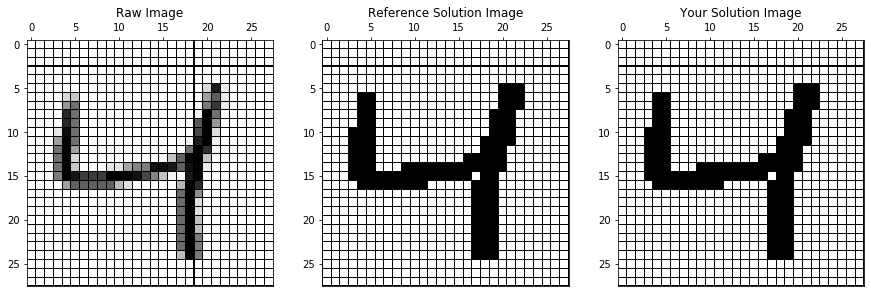

In [49]:
(orig_image, ref_image, test_im, success_thr) = show_test_cases(lambda x: get_thresholded(x, 20), task_id='1_V')

assert success_thr

### **Warning**: 
Do not leave the previous cell hanging; unless you enter "s" to stop it, you cannot evaluate other cells.

In [50]:
# Checking against the pre-computed test database
test_results = test_case_checker(get_thresholded, task_id=1)
assert test_results['passed'], test_results['message']

In [51]:
train_images_threshed = get_thresholded(train_images_raw, threshold=20)
eval_images_threshed = get_thresholded(eval_images_raw, threshold=20)

## 0.3 Creating "Bounding Box" Images

### 0.3.1 Finding Inky Rows

# <span style="color:blue">Task 2</span>

Write the function `get_is_row_inky` that finds the rows with ink pixels and takes following the arguments:

* `images`: A numpy array with the shape `(N,height,width)`, where 
    * `N` is the number of samples and could be anything,
    * `height` is each individual image's height in pixels (i.e., number of rows in each image),
    * and `width` is each individual image's width in pixels (i.e., number of columns in each image).
   
      * Do not assume anything about `images`'s dtype or the number of samples or the `height` or the `width`.

and returns the following:

* `is_row_inky`: A numpy array with the shape `(N, height)`, and the `bool` dtype. 
    * `is_row_inky[i,j]` should be True if **any** of the pixels in the `j`th row of the `i`th image was an ink pixel, and False otherwise.

In [52]:
def get_is_row_inky(images):
    """
    Finds the rows with ink pixels.

        Parameters:
                images (np,array): A numpy array with the shape (N, height, width)

        Returns:
                is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype. 
    """
    
    # your code here
    is_row_inky = np.any(images != 0, axis = 2)
    
    return is_row_inky

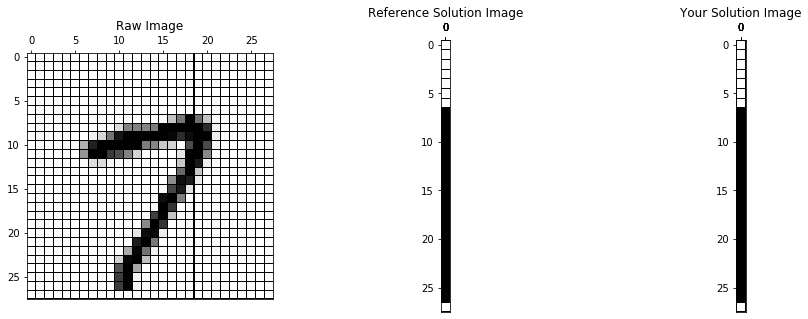

In [53]:
(orig_image, ref_image, test_im, success_is_row_inky) = show_test_cases(lambda x: np.expand_dims(get_is_row_inky(x), axis=2), 
                                                                        task_id='2_V')

assert success_is_row_inky

### **Warning**: 
Do not leave the previous cell hanging; unless you enter "s" to stop it, you cannot evaluate other cells.

In [54]:
# Checking against the pre-computed test database
test_results = test_case_checker(get_is_row_inky, task_id=2)
assert test_results['passed'], test_results['message']

### 0.3.2 Finding Inky Columns

# <span style="color:blue">Task 3</span>

Similar to `get_is_row_inky`, Write the function `get_is_col_inky` that finds the columns with ink pixels and takes following the arguments:

* `images`: A numpy array with the shape `(N,height,width)`, where 
    * `N` is the number of samples and could be anything,
    * `height` is each individual image's height in pixels (i.e., number of rows in each image),
    * and `width` is each individual image's width in pixels (i.e., number of columns in each image).
   
      * **Note**: Do not assume anything about `images`'s dtype or the number of samples or the `height` or the `width`.

and returns the following:

* `is_col_inky`: A numpy array with the shape `(N, width)`, and the `bool` dtype. 
    * `is_col_inky[i,j]` should be True if **any** of the pixels in the `j`th column of the `i`th image was an ink pixel, and False otherwise.

In [55]:
def get_is_col_inky(images):
    """
    Finds the columns with ink pixels.

        Parameters:
                images (np.array): A numpy array with the shape (N,height,width).
                
        Returns:
                is_col_inky (np.array): A numpy array with the shape (N, width), and the bool dtype. 
    """
    
    # your code here
    is_col_inky = np.any(images != 0, axis = 1)
    
    return is_col_inky

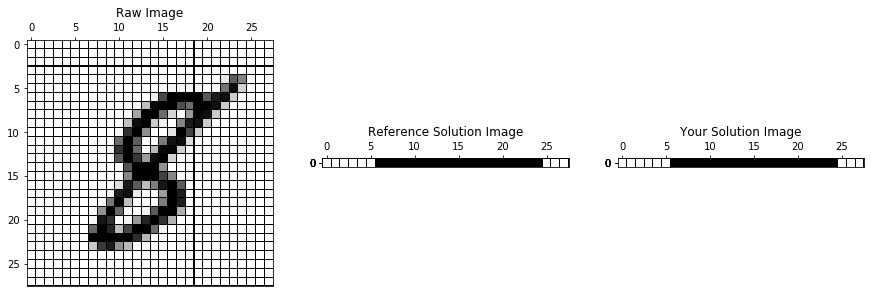

In [57]:
(orig_image, ref_image, test_im, success_is_col_inky) = show_test_cases(lambda x: np.expand_dims(get_is_col_inky(x), axis=1), 
                                                                        task_id='3_V')

assert success_is_col_inky

### **Warning**: 
Do not leave the previous cell hanging; unless you enter "s" to stop it, you cannot evaluate other cells.

In [58]:
# Checking against the pre-computed test database
test_results = test_case_checker(get_is_col_inky, task_id=3)
assert test_results['passed'], test_results['message']

### 0.3.3.1 Getting the First Inky Rows

# <span style="color:blue">Task 4</span>

Write the function `get_first_ink_row_index` that finds the first row containing ink pixels and takes following the arguments:

* `is_row_inky`: A numpy array with the shape `(N, height)`, and the `bool` dtype. This is the output of the `get_is_row_inky` function that you implemented before.
    
and returns the following:

* `first_ink_rows`: A numpy array with the shape `(N,)`, and the `int64` dtype. 
    * `first_ink_rows[i]` is the index of the first row containing any ink pixel in the `i`th image. The indices should be **zero-based**.

In [59]:
def get_first_ink_row_index(is_row_inky):
    """
     Finds the first row containing ink pixels

        Parameters:
                is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype. 
                This is the output of the get_is_row_inky function that you implemented before.
                
        Returns:
                first_ink_rows (np.array): A numpy array with the shape (N,), and the int64 dtype. 
    """
    
    # your code here
    first_ink_rows = np.argmax(is_row_inky, axis = 1)
    
    return first_ink_rows

In [60]:
# Performing sanity checks on your implementation
assert np.array_equal(get_first_ink_row_index(get_is_row_inky(train_images_threshed[:10,:,:])), 
                      np.array([5, 4, 5, 5, 7, 5, 4, 5, 5, 4]))


In [61]:
# Checking against the pre-computed test database
test_results = test_case_checker(get_first_ink_row_index, task_id=4)
assert test_results['passed'], test_results['message']

### 0.3.3.2 Getting the First Inky Columns

Since `is_row_inky` and `is_col_inky` have the same data structure, we could re-use the `get_first_ink_row_index` to define a corresponding function `get_first_ink_col_index` for columns; both of them have the same functionality and are essentially the same.

In [62]:
def get_first_ink_col_index(is_col_inky):
    return get_first_ink_row_index(is_col_inky)

### 0.3.4.1 Getting the Last Inky Rows

# <span style="color:blue">Task 5</span>

Write the function `get_last_ink_row_index` that finds the last row containing ink pixels and takes following the arguments:

* `is_row_inky`: A numpy array with the shape `(N, height)`, and the `bool` dtype. This is the output of the `get_is_row_inky` function that you implemented before.
    
and returns the following:

* `last_ink_rows`: A numpy array with the shape `(N,)`, and the `int64` dtype. 
    * `last_ink_rows[i]` is the index of the last row containing any ink pixel in the `i`th image. The indices should be **zero-based**.

In [63]:
def get_last_ink_row_index(is_row_inky):
    """
    Finds the last row containing ink pixels.

        Parameters:
                is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype. 
                This is the output of the get_is_row_inky function that you implemented before.
                
        Returns:
                last_ink_rows (np.array): A numpy array with the shape (N,), and the int64 dtype. 
    """
    
    # your code here
    last = np.argmax(np.flip(is_row_inky, axis = 1), axis = 1)
    last_ink_rows = is_row_inky.shape[1] - 1- last
    
    return last_ink_rows

In [64]:
# Performing sanity checks on your implementation
assert (get_last_ink_row_index(get_is_row_inky(train_images_threshed[:10,:,:])) == 
        np.array([24, 23, 24, 24, 26, 22, 23, 24, 24, 23])).all()

# Checking against the pre-computed test database
test_results = test_case_checker(get_last_ink_row_index, task_id=5)
assert test_results['passed'], test_results['message']

### 0.3.4.2 Getting the Last Inky Columns

Since `is_row_inky` and `is_col_inky` have the same data structure, we could re-use the `get_last_ink_row_index` to define a corresponding function `get_last_ink_col_index` for columns; both of them have the same functionality and are essentially the same.

In [65]:
def get_last_ink_col_index(is_col_inky):
    return get_last_ink_row_index(is_col_inky)

### 0.3.5 The Final "Bounding Box" Pre-processor

# <span style="color:blue">Task 6</span>

Write the function `get_images_bb` that applies the "Bounding Box" pre-processing step and takes the following arguments:

* `images`: A numpy array with the shape `(N,height,width)`, where 
    * `N` is the number of samples and could be anything,
    * `height` is each individual image's height in pixels (i.e., number of rows in each image),
    * and `width` is each individual image's width in pixels (i.e., number of columns in each image).
   
    Do not assume anything about `images`'s dtype or number of samples.
    
* `bb_size`: A scalar with the default value of 20, and represents the desired bounding box size.

and returns the following:

* `images_bb`: A numpy array with the shape `(N,bb_size,bb_size)`, and the same dtype as `images`. 

We have provided a template function that uses the previous functions and only requires you to fill in the missing parts. It also handles the input shapes in an agnostic way.

**Important Note**: Make sure that you use the `np.roll` function for this implementation.

**Clarification with Example**: Here we will describe in exact details how to produce the output image.

Let's focus on a single raw image, and let's call it `X`. We wish to produce the output image `Y`. Let's assume `X` has a `height` and a `width` of 28, and `bb_size` is 20. This means that `X` has a shape of `(28,28)` and `Y` has a shape of `(20,20)`. As a visual example, we'll assume that `X` is the left image (i.e., the raw image) shown below, and `Y` is the right image (i.e., the solution image). 

![alt text](./images/bb_example.png "Bounding Box Definitions")

Let's define the first/last inky rows with an example:
 * The **first inky row** of `X` has an index of $r_1$. In the picture example, we have $r_1=6$. This means that `X[5,:]` has no ink in it, and `X[6,:]` has some ink elements in it.
 * The **last inky row** of `X` has an index of $r_2$. In the picture example, we have $r_2=25$. This means that `X[25,:]` has some ink in it, and `X[26,:]` has no ink in it.
 
Let's define the first/last inky columns in a similar manner:
 * The **first inky column** of `X` has an index of $c_1$. In the picture example, we have $c_1=5$. This means that `X[:,4]` has no ink in it, and `X[:,5]` has some ink elements in it.
 * The **last inky column** of `X` has an index of $c_2$. In the picture example, we have $c_2=20$. This means that `X[:,20]` has some ink in it, and `X[:,21]` has no ink in it.
 
 
Now let's define the **inky middle row/column** of the raw image.

 * The **inky middle row** of the raw image is $r_m = \lfloor \frac{r_1 + r_2 + 1}{2} \rfloor$. In this example, we have $r_m=16$, which is also shown in the picture.
 * The **inky middle column** of the raw image is $c_m = \lfloor \frac{c_1 + c_2 + 1}{2} \rfloor$. In this example, we have $c_m=13$, which is also shown in the picture.


The middle row index of the output image is $r_{out} = \lfloor \frac{\text{bb_size}}{2} \rfloor$. Similarly, we have the middle column index of the output image $c_{out} = \lfloor \frac{\text{bb_size}}{2} \rfloor$. In this example, we have $r_{out}=c_{out}=10$, which are marked with blue boxes in the solution image.

The **middle inky pixel of the raw image** is `X[r_m, c_m]`. This middle inky pixel is colored red in the raw image for clarification.

The **middle inky pixel of the solution image** is `Y[r_out, c_out]`. This middle inky pixel is colored red in the solution image for clarification

You must shift the raw image in a way that the **middle inky pixel of the raw image** gets placed on the **middle inky pixel of the solution image**. In other words, the red pixels should be placed on top of each other.

You will also have to cut some of rows/columns of the solution image properly to make sure it would have a shape of `(bb_size, bb_size)`. Furthermore, this whole discussion was for a single image, but you will have to take care of a batch of images as input, and produce a batch of bounded-box images as an output, and make sure all the dimensions/shapes work out properly.

In [66]:
def get_images_bb(images, bb_size=20):
    """
    Applies the "Bounding Box" pre-processing step to images.

        Parameters:
                images (np.array): A numpy array with the shape (N,height,width)
                
        Returns:
                images_bb (np.array): A numpy array with the shape (N,bb_size,bb_size), 
                and the same dtype as images. 
    """
    
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll add a dummy dimension to be consistent
        images_ = images.reshape(1,*images.shape)
    else:
        # Otherwise, we'll just work with what's given
        images_ = images
        
    is_row_inky = get_is_row_inky(images_)
    is_col_inky = get_is_col_inky(images_)
    
    first_ink_rows = get_first_ink_row_index(is_row_inky)
    last_ink_rows = get_last_ink_row_index(is_row_inky)
    first_ink_cols = get_first_ink_col_index(is_col_inky)
    last_ink_cols = get_last_ink_col_index(is_col_inky)
    
    # your code here
    
    N, height, width = images_.shape
    images_bb = np.zeros((N, bb_size, bb_size), dtype=images.dtype)
    
    for i in range(images_.shape[0]):
        r1, r2 = first_ink_rows[i], last_ink_rows[i]
        c1, c2 = first_ink_cols[i], last_ink_cols[i]
        r_m = int((r1 + r2 + 1) // 2)
        c_m = int((c1 + c2 + 1) // 2)
        r_out = bb_size//2
        c_out = bb_size//2
        shifted_image = np.roll(images_[i], shift=(r_out - r_m, c_out - c_m), axis=(0, 1))

        cropped_image = shifted_image[
            max(0, r_out - r_m):max(0, r_out - r_m) + bb_size,
            max(0, c_out - c_m):max(0, c_out - c_m) + bb_size
        ]
        images_bb[i, :cropped_image.shape[0], :cropped_image.shape[1]] = cropped_image
    
        
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll get rid of the dummy dimension
        return images_bb[0]
    else:
        # Otherwise, we'll just work with what's given
        return images_bb

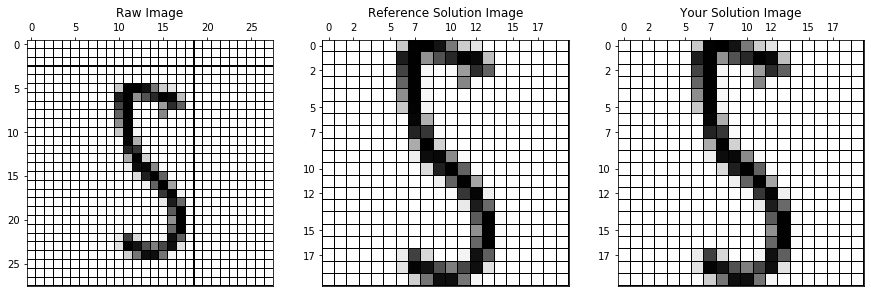

In [67]:
(orig_image, ref_image, test_im, success_bb) = show_test_cases(get_images_bb, task_id='6_V')

assert success_bb

### **Warning**: 
Do not leave the previous cell hanging; unless you enter "s" to stop it, you cannot evaluate other cells.

In [68]:
# Checking against the pre-computed test database
test_results = test_case_checker(get_images_bb, task_id=6)
assert test_results['passed'], test_results['message']

In [69]:
train_images_bb = get_images_bb(train_images_threshed)
eval_images_bb = get_images_bb(eval_images_threshed)

### 0.3.6 The Final "Stretched Bounding Box" Pre-processor

# <span style="color:blue">Task 7</span>

Similarly, write the function `get_images_sbb` that applies the "Stretched Bounding Box" pre-processing step and takes following the arguments:

* `images`: A numpy array with the shape `(N,height,width)`, where 
    * `N` is the number of samples and could be anything,
    * `height` is each individual image's height in pixels (i.e., number of rows in each image),
    * and `width` is each individual image's width in pixels (i.e., number of columns in each image).
   
    Do not assume anything about `images`'s dtype or number of samples.
    
* `bb_size`: A scalar with the default value of 20, and represents the desired bounding box size.

and returns the following:

* `images_sbb`: A numpy array with the shape `(N,bb_size,bb_size)`, and the same dtype and the range of values as `images`. 


The `get_images_sbb` should find a tight-canvas of the inky area in each input image, and stretch it out to fill the full height and width of the output bounding-box. Please see the visual example in the **Assignment Summary** section; the right image should supposedly be the `get_images_sbb` function's output.

We have provided a template function that uses the previous functions and only requires you to fill in the missing parts. It also handles the input shapes in an agnostic way.

**Hint**: Make sure that you use the `skimage.transform.resize` function from the skimage library. Read about it at https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=resize#skimage.transform.resize. You may need to pay attention to the `preserve_range` argument.

In [72]:
def get_images_sbb(images, bb_size=20):
    """
    Applies the "Stretched Bounding Box" pre-processing step to images.

        Parameters:
                images (np.array): A numpy array with the shape (N,height,width)
                
        Returns:
                images_sbb (np.array): A numpy array with the shape (N,bb_size,bb_size), 
                and the same dtype and the range of values as images. 
    """
    
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll add a dummy dimension to be consistent
        images_ = images.reshape(1,*images.shape)
    else:
        # Otherwise, we'll just work with what's given
        images_ = images
        
    is_row_inky = get_is_row_inky(images)
    is_col_inky = get_is_col_inky(images)
    
    first_ink_rows = get_first_ink_row_index(is_row_inky)
    last_ink_rows = get_last_ink_row_index(is_row_inky)
    first_ink_cols = get_first_ink_col_index(is_col_inky)
    last_ink_cols = get_last_ink_col_index(is_col_inky)
    
    # your code here
    N, height, width = images_.shape
    images_sbb = np.zeros((N, bb_size, bb_size), dtype=images.dtype)

    for i in range(N):
        r1, r2 = first_ink_rows[i], last_ink_rows[i]
        c1, c2 = first_ink_cols[i], last_ink_cols[i]

        cropped_image = images_[i, r1:r2+1, c1:c2+1] 

        resized_image = resize(cropped_image, (bb_size, bb_size), preserve_range=True, anti_aliasing=True)

        images_sbb[i] = resized_image
        
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll get rid of the dummy dimension
        return images_sbb[0]
    else:
        # Otherwise, we'll just work with what's given
        return images_sbb

The reference and solution images are not the same...
ref_image[0, 19]=2
test_image[0, 19]=3
I will return the images so that you will be able to diagnose the issue and resolve it...


AssertionError: 

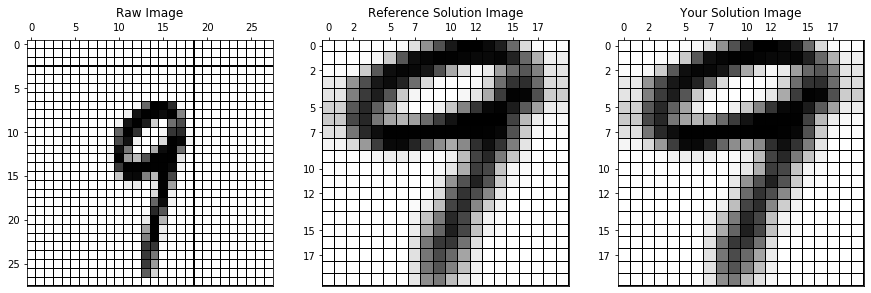

In [73]:
(orig_image, ref_image, test_im, success_sbb) = show_test_cases(get_images_sbb, task_id='7_V')

assert success_sbb

### **Warning**: 
Do not leave the previous cell hanging; unless you enter "s" to stop it, you cannot evaluate other cells.

In [ ]:
# Checking against the pre-computed test database
test_results = test_case_checker(get_images_sbb, task_id=7)
assert test_results['passed'], test_results['message']

In [84]:
if perform_computation:
    print('This is gonna take a while to finish...')
    %time train_images_sbb = get_images_sbb(train_images_threshed)
    %time eval_images_sbb = get_images_sbb(eval_images_threshed)

This is gonna take a while to finish...
CPU times: user 41.1 s, sys: 120 ms, total: 41.2 s
Wall time: 41.2 s
CPU times: user 7.04 s, sys: 19.7 ms, total: 7.06 s
Wall time: 7.08 s


# 1. Naive Bayes Performances

# <span style="color:blue">Task 8</span>

Similarly, write the function `train_nb_eval_acc` that trains Naive Bayes models and takes following the arguments:

* `train_images`: A numpy array with the shape `(N,height,width)`, where 
    * `N` is the number of samples and could be anything,
    * `height` is each individual image's height in pixels (i.e., number of rows in each image),
    * and `width` is each individual image's width in pixels (i.e., number of columns in each image).
 
    Do not assume anything about `images`'s dtype or number of samples.

* `train_labels`: A numpy array with the shape `(N,)`, where `N` is the number of samples and has the `int64` dtype.

* `eval_images`: The evaluation images with similar characteristics to `train_images`.

* `eval_labels`: The evaluation labels with similar characteristics to `train_labels`.
    
* `density_model`: A string that is either `'Gaussian'` or `'Bernoulli'`. In the former (resp. latter) case, you should train a Naive Bayes with the Gaussian (resp. Bernoulli) density model.

and returns the following:

* `eval_acc`: a floating number scalar between 0 and 1 that represents the accuracy of the trained model on the evaluation data.

We have provided a template function that uses the previous functions and only requires you to fill in the missing parts. It also handles the input shapes in an agnostic way.

**Note**: You do not need to implement the Naive Bayes classifier from scratch in this assignment; Make sure you use `scikit-learn`'s Naive Bayes module for training and prediction in this task. We have already imported these two functions in the first code cell:

  * `from sklearn.naive_bayes import GaussianNB, BernoulliNB`

In [81]:
from sklearn.metrics import accuracy_score
def train_nb_eval_acc(train_images, train_labels, eval_images, eval_labels, density_model='Gaussian'):
    """
    Trains Naive Bayes models, apply the model, and return an accuracy.

        Parameters:
                train_images (np.array): A numpy array with the shape (N,height,width)
                train_labels (np.array): A numpy array with the shape (N,), where N is the number of samples and 
                has the int64 dtype.
                eval_images (np.array): The evaluation images with similar characteristics to train_images.
                eval_labels (np.array): The evaluation labels with similar characteristics to train_labels.
                density_model (string): A string that is either 'Gaussian' or 'Bernoulli'. 
                
        Returns:
                eval_acc (np.float): a floating number scalar between 0 and 1 that 
                represents the accuracy of the trained model on the evaluation data.
    """
    
    assert density_model in ('Gaussian', 'Bernoulli')
    
    # your code here
    N, height, width = train_images.shape
    train_images_flat = train_images.reshape(N, height * width)
    
    N_eval, height_eval, width_eval = eval_images.shape
    eval_images_flat = eval_images.reshape(N_eval, height_eval * width_eval)
    
    if density_model == 'Gaussian':
        model = GaussianNB()
    elif density_model == 'Bernoulli':
        model = BernoulliNB()
        
    model.fit(train_images_flat, train_labels)
    
    pred = model.predict(eval_images_flat)
    
    eval_acc = accuracy_score(eval_labels, pred)
    
    return eval_acc

# Don't mind the following lines and do not change them
train_nb_eval_acc_gauss = lambda *args, **kwargs: train_nb_eval_acc(*args, density_model='Gaussian', **kwargs)
train_nb_eval_acc_bern = lambda *args, **kwargs: train_nb_eval_acc(*args, density_model='Bernoulli', **kwargs)

In [82]:
# Checking against the pre-computed test database
test_results = test_case_checker(train_nb_eval_acc_gauss, task_id='8_G')
assert test_results['passed'], test_results['message'] # Gaussian Model Test Results

test_results = test_case_checker(train_nb_eval_acc_bern, task_id='8_B')
assert test_results['passed'], test_results['message'] # Bernoulli Model Test Results

In [83]:
df = None
if perform_computation:
    acc_nbg_thr = train_nb_eval_acc(train_images_threshed, train_labels, 
                                    eval_images_threshed, eval_labels, density_model='Gaussian')
    acc_nbb_thr = train_nb_eval_acc(train_images_threshed, train_labels, 
                                    eval_images_threshed, eval_labels, density_model='Bernoulli')
    acc_nbg_sbb = train_nb_eval_acc(train_images_sbb, train_labels, 
                                    eval_images_sbb, eval_labels, density_model='Gaussian')
    acc_nbb_sbb = train_nb_eval_acc(train_images_sbb, train_labels, 
                                    eval_images_sbb, eval_labels, density_model='Bernoulli')

    df = pd.DataFrame([('Untouched images', acc_nbg_thr, acc_nbb_thr),
                       ('Stretched bounding box', acc_nbg_sbb, acc_nbb_sbb)
                      ], columns = ['Accuracy' , 'Gaussian', 'Bernoulli'])

df

,Accuracy,Gaussian,Bernoulli
0,Untouched images,0.5491,0.843
1,Stretched bounding box,0.8141,0.806


# 2. Decision Forests Performances

# <span style="color:blue">Task 9</span>

Similarly, write the function `train_tree_eval_acc` that trains Decision Forest models and takes following the arguments:

* `train_images`: A numpy array with the shape `(N,height,width)`, where 
    * `N` is the number of samples and could be anything,
    * `height` is each individual image's height in pixels (i.e., number of rows in each image),
    * and `width` is each individual image's width in pixels (i.e., number of columns in each image).
 
    Do not assume anything about `images`'s dtype or number of samples.

* `train_labels`: A numpy array with the shape `(N,)`, where `N` is the number of samples and has the `int64` dtype.

* `eval_images`: The evaluation images with similar characteristics to `train_images`.

* `eval_labels`: The evaluation labels with similar characteristics to `eval_labels`.
    
* `tree_num`: An integer number representing the number of trees in the dicision forest.

* `tree_depth`: An integer number representing the maximum tree depth in the dicision forest.

* `random_state`: An integer with a default value of 12345 that should be passed to the scikit-learn's classifer constructor for reproducibility and auto-grading (**Do not assume** that it is always 12345).

and returns the following:

* `eval_acc`: A floating number scalar between 0 and 1 that represents the accuracy of the trained model on the evaluation data.

We have provided a template function that uses the previous functions and only requires you to fill in the missing parts. It also handles the input shapes in an agnostic way.

**Note**: You do not need to implement the Random Forest classifier from scratch in this assignment; Make sure you use `scikit-learn`'s Random Forest module for training and prediction in this task. We have already imported this function in the first code cell:

  * `from sklearn.ensemble import RandomForestClassifier`
  * You may need to set "shuffle = True" due to a known sklearn issue.

In [85]:
def train_tree_eval_acc(train_images, train_labels, eval_images, eval_labels, tree_num=10, tree_depth=4, random_state=12345):
    """
    Trains Naive Bayes models, apply the model, and return an accuracy.

        Parameters:
                train_images (np.array): A numpy array with the shape (N,height,width)
                train_labels (np.array): A numpy array with the shape (N,), where N is the number of samples and 
                has the int64 dtype.
                eval_images (np.array): The evaluation images with similar characteristics to train_images.
                eval_labels (np.array): The evaluation labels with similar characteristics to train_labels.
                tree_num (int): An integer number representing the number of trees in the decision forest.
                tree_depth (int): An integer number representing the maximum tree depth in the decision forest.
                random_state (int): An integer with a default value of 12345 that should be passed to 
                the scikit-learn's classifer constructor for reproducibility and auto-grading
                
        Returns:
                eval_acc (np.float): a floating number scalar between 0 and 1 that 
                represents the accuracy of the trained model on the evaluation data.
    """
    
    tree_num = int(tree_num)
    tree_depth = int(tree_depth)
    random_state = int(random_state)
    
    # your code here
    N, height, width = train_images.shape
    train_images_flat = train_images.reshape(N, height * width)
    
    N_eval, height_eval, width_eval = eval_images.shape
    eval_images_flat = eval_images.reshape(N_eval, height_eval * width_eval)
    
    model = RandomForestClassifier(n_estimators = tree_num, max_depth = tree_depth, random_state = random_state)
    
    model.fit(train_images_flat, train_labels)
    
    pred = model.predict(eval_images_flat)
    
    eval_acc = accuracy_score(eval_labels, pred)
    
    return eval_acc

In [86]:
# Checking against the pre-computed test database
test_results = test_case_checker(train_tree_eval_acc, task_id=9)
assert test_results['passed'], test_results['message']

## 2.1 Accuracy on the Untouched Images

In [87]:
df = None
if perform_computation:
    tree_nums = [10, 20, 30]
    tree_depths = [4, 8, 16]

    train_images = train_images_threshed
    eval_images = eval_images_threshed
    acc_arr_unt = np.zeros((len(tree_nums), len(tree_depths)))
    for row, tree_num in enumerate(tree_nums):
        for col, tree_depth in enumerate(tree_depths):
            acc_arr_unt[row, col] = train_tree_eval_acc(train_images, train_labels, eval_images, eval_labels, 
                                                        tree_num=tree_num, tree_depth=tree_depth, random_state=12345)

    df = pd.DataFrame([(f'#trees = {tree_num}', *tuple(acc_arr_unt[row])) for row, tree_num in enumerate(tree_nums)],
                      columns = ['Accuracy'] + [f'depth={tree_depth}'for col, tree_depth in enumerate(tree_depths)])

    print('Untouched Images:')
df

Untouched Images:


,Accuracy,depth=4,depth=8,depth=16
0,#trees = 10,0.7496,0.8923,0.9489
1,#trees = 20,0.7707,0.9127,0.9585
2,#trees = 30,0.7883,0.9169,0.9630


## 2.2 Accuracy on the "Stretched Bounding Box" Images

In [88]:
df = None
if perform_computation:
    tree_nums = [10, 20, 30]
    tree_depths = [4, 8, 16]

    train_images = train_images_sbb
    eval_images = eval_images_sbb
    acc_arr_sbb = np.zeros((len(tree_nums), len(tree_depths)))
    for row, tree_num in enumerate(tree_nums):
        for col, tree_depth in enumerate(tree_depths):
            acc_arr_sbb[row, col] = train_tree_eval_acc(train_images, train_labels, eval_images, eval_labels, 
                                                        tree_num=tree_num, tree_depth=tree_depth, random_state=12345)

    df = pd.DataFrame([(f'#trees = {tree_num}', *tuple(acc_arr_sbb[row])) for row, tree_num in enumerate(tree_nums)],
                      columns = ['Accuracy'] + [f'depth = {tree_depth}'for col, tree_depth in enumerate(tree_depths)])

    print('Stretched Bounding Box Images:')
df

Stretched Bounding Box Images:


,Accuracy,depth = 4,depth = 8,depth = 16
0,#trees = 10,0.7241,0.8904,0.9447
1,#trees = 20,0.7517,0.9047,0.9542
2,#trees = 30,0.7564,0.9071,0.9548


## 2.3 Accuracy on the "Bounding Box" Images

In [89]:
df = None
if perform_computation:
    tree_nums = [10, 20, 30]
    tree_depths = [4, 8, 16]

    train_images = train_images_bb
    eval_images = eval_images_bb
    acc_arr_bb = np.zeros((len(tree_nums), len(tree_depths)))
    for row, tree_num in enumerate(tree_nums):
        for col, tree_depth in enumerate(tree_depths):
            acc_arr_bb[row, col] = train_tree_eval_acc(train_images, train_labels, eval_images, eval_labels, 
                                                       tree_num=tree_num, tree_depth=tree_depth, random_state=12345)

    df = pd.DataFrame([(f'#trees = {tree_num}', *tuple(acc_arr_bb[row])) for row, tree_num in enumerate(tree_nums)],
                      columns = ['Accuracy'] + [f'depth = {tree_depth}'for col, tree_depth in enumerate(tree_depths)])

    print('Bounding Box Images:')
df

Bounding Box Images:


,Accuracy,depth = 4,depth = 8,depth = 16
0,#trees = 10,0.7406,0.8884,0.9503
1,#trees = 20,0.7716,0.9046,0.9592
2,#trees = 30,0.7801,0.9092,0.9611
